In [1]:
import random
import numpy as np

from deap import base
from deap import creator
from deap import tools

In [2]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

# Setup the System
- genome is now 3 params: distance OH1, Distance Oh2, angle H1OH2.
- Molecule will always be in xy plane


In [3]:
toolbox = base.Toolbox()

toolbox.register("init_gene", random.random)
toolbox.register("init_individual", tools.initRepeat, 
                 creator.Individual, toolbox.init_gene, 3)

toolbox.register("init_population", tools.initRepeat, 
                 list, toolbox.init_individual)

In [4]:
from pyscf.gto import Mole
from pyscf.scf import RHF

def build_molecule_from_genome(genome):
    
    atoms = [
        ("O", 0, 0, 0),
        ("H", 0, genome[0], 0),
        ("H", genome[1] * np.cos(genome[2]), genome[1] * np.sin(genome[2]), 0)
    ]
    
    mol = Mole()
    mol.atom = atoms
    mol.basis = "sto-3g"
    mol.build()
    return mol
    
def evaluateFitness(individual):
    
    mol = build_molecule_from_genome(individual)
    
    mf = RHF(mol)
    mf.verboseose = 1
    E = mf.scf()
    
    # this shit has to be a tuple!!
    return E,

toolbox.register("evaluate", evaluateFitness)

/home/jo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05) # flip gene with 0.05 % probability
toolbox.register("select", tools.selTournament, tournsize=3)

# Do the Optimazation 

In [6]:
PROBABILITY_CROSSING = 0.5
PROBABILITY_MUTATION = 0.5

MAX_ITERATIONS = 1000

CONVERGENCE_THRESHOLD = 1e-10

E_old = 1e10

In [7]:
SIZE_POPULATION = 30

population = toolbox.init_population(n=SIZE_POPULATION)

In [8]:
fitnesses = list(map(toolbox.evaluate, population))

for ind, fit in zip(population, fitnesses):
    ind.fitness.values = fit

<class 'pyscf.scf.hf.RHF'> does not have attributes  verboseose


converged SCF energy = -50.3615570102207
converged SCF energy = -74.1622522112728
converged SCF energy = -71.5852541026986
converged SCF energy = -68.4397294410335
converged SCF energy = -70.3940381951987
converged SCF energy = -73.6948715531171
converged SCF energy = 397.979476121848
converged SCF energy = -73.8849302665517
converged SCF energy = -73.2776533211309
converged SCF energy = 109.634992390971
converged SCF energy = -74.1143678785617
converged SCF energy = 632.166342831182
converged SCF energy = -72.6423659407072
converged SCF energy = -73.9300554556457
converged SCF energy = -74.9264137562848
converged SCF energy = -74.7061076542784
converged SCF energy = -67.5301897715061
converged SCF energy = -74.0520254132299
converged SCF energy = -73.6577364111559
converged SCF energy = 689.321062484134
converged SCF energy = -38.7764321456016
converged SCF energy = 653.940131443484
converged SCF energy = -47.8755495539537
converged SCF energy = -74.4899823817094
converged SCF energy 

In [9]:
# create a list of fitness values
fitness_values = [ind.fitness.values[0] for ind in population]

# Begin the evolution
for i in range(MAX_ITERATIONS):

    # Select next generation
    offspring = toolbox.select(population, len(population))
    offspring = list(map(toolbox.clone, offspring))

    # do cross over
    for child1, child2 in zip(offspring[::2], offspring[1::2]):

        if random.random() < PROBABILITY_CROSSING:
            toolbox.mate(child1, child2)

            del child1.fitness.values
            del child2.fitness.values
            
    # do mutation
    for mutant in offspring:
        if random.random() < PROBABILITY_MUTATION:
            toolbox.mutate(mutant)
            del mutant.fitness.values
    
    # recalculate fitness values of mates and mutants
    invalid_individuals = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_individuals)
    for ind, fit in zip(invalid_individuals, fitnesses):
        ind.fitness.values = fit
    
    population[:] = offspring
    
    # update list of fitness value
    fitness_values = [ind.fitness.values[0] for ind in population]
    
    #E = sum(fitness_values) / len(fitness_values)
    E = min(fitness_values)
    print(E_old, E)
    
    if np.abs(E - E_old) < CONVERGENCE_THRESHOLD:
        break
    else:
        E_old = E
        
    
    

converged SCF energy = -74.326031251344
converged SCF energy = -73.6979968326005
converged SCF energy = -73.3516059892936
converged SCF energy = -74.2662410450059
converged SCF energy = -74.4899823817095
converged SCF energy = -74.7061076542784
converged SCF energy = -74.9264137562848
converged SCF energy = -74.1248554987549
converged SCF energy = -74.4240277603575
converged SCF energy = -74.0824305742793
converged SCF energy = -68.1316971013686
converged SCF energy = -40.3831925041364
converged SCF energy = -72.7593738764363


/home/jo/Repos/pyscf/pyscf/gto/mole.py:1045: RuntimeWarning: divide by zero encountered in true_divide
  e = (qq/r).sum() * .5
/home/jo/Repos/pyscf/pyscf/scf/hf.py:154: RuntimeWarning: invalid value encountered in double_scalars
  cycle+1, e_tot, e_tot-last_hf_e, norm_gorb, norm_ddm)
/home/jo/Repos/pyscf/pyscf/scf/hf.py:156: RuntimeWarning: invalid value encountered in double_scalars
  if (abs(e_tot-last_hf_e) < conv_tol and norm_gorb < conv_tol_grad):


converged SCF energy = inf
converged SCF energy = inf


/home/jo/Repos/pyscf/pyscf/scf/hf.py:181: RuntimeWarning: invalid value encountered in double_scalars
  scf_conv = (abs(e_tot-last_hf_e) < conv_tol*10 or
/home/jo/Repos/pyscf/pyscf/scf/hf.py:184: RuntimeWarning: invalid value encountered in double_scalars
  e_tot, e_tot-last_hf_e, norm_gorb, norm_ddm)


converged SCF energy = -74.7999765600031
converged SCF energy = -74.2802261477563
converged SCF energy = -74.3504297346412
converged SCF energy = -73.6577364111559
converged SCF energy = -74.4899823817095
converged SCF energy = inf
converged SCF energy = -74.799976560003
converged SCF energy = -74.1622522112728
converged SCF energy = -73.6948715531172
converged SCF energy = -74.0387141695876
converged SCF energy = -74.0387141695876
10000000000.0 -74.92641375628482
converged SCF energy = inf
converged SCF energy = -74.8487136956568
converged SCF energy = -73.4513922613457
converged SCF energy = -74.2324473857935
converged SCF energy = -74.9264137562849
converged SCF energy = inf
converged SCF energy = -74.0900547815952
converged SCF energy = -74.318598038177
converged SCF energy = -74.93207160293
converged SCF energy = -74.0527390738392
converged SCF energy = -74.4899823817095
converged SCF energy = -74.2802261477563
converged SCF energy = -74.1368720382738
converged SCF energy = -74.89

In [10]:
best_ind = tools.selBest(population, 1)[0]
print(best_ind.fitness.values)

(-74.93519162694226,)


# Checking the Result 

In [13]:
mol = build_molecule_from_genome(best_ind)


[0, 0, 0.8652759592715109]

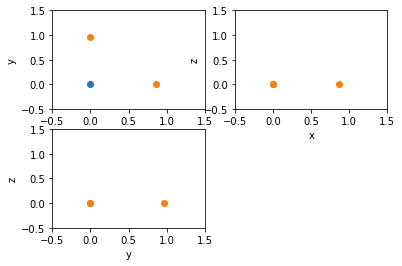

In [15]:
import matplotlib.pylab as plt

x = [t[1] for t in mol.atom]
y = [t[2] for t in mol.atom]
z = [t[3] for t in mol.atom]

lower, upper = -0.5, 1.5

plt.subplot(2, 2, 1)
plt.scatter(x[0], y[0], label="C")
plt.scatter(x[1:], y[1:], label="H")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(lower, upper)
plt.ylim(lower, upper)

plt.subplot(2, 2, 2)
plt.scatter(x[0], z[0], label="C")
plt.scatter(x[1:], z[1:], label="H")
plt.xlabel("x")
plt.ylabel("z")
plt.xlim(lower, upper)
plt.ylim(lower, upper)

plt.subplot(2, 2, 3)
plt.scatter(y[0], z[0], label="C")
plt.scatter(y[1:], z[1:], label="H")
plt.xlabel("y")
plt.ylabel("z")
plt.xlim(lower, upper)
plt.ylim(lower, upper)

plt.show()

In [ ]:
O  = np.array([x[0], y[0], z[0]])
H1 = np.array([x[1], y[1], z[1]])
H2 = np.array([x[2], y[2], z[2]])


OH1 = C - H1
OH2 = C - H2
distance_C_H1 = np.linalg.norm(CH1)
distance_C_H2 = np.linalg.norm(CH2)

angle = np.arccos(np.dot(CH1, CH2) / (distance_C_H1 * distance_C_H2))

print("Distance C-H1: {0},\nDistance C-H2: {1},\nAngle Distance C-H1: {2}".format(
    distance_C_H1,
    distance_C_H2,
    angle / (2 * np.pi) * 360
))